# Self Organizing Map and ANN for Credit Frauds

In this notebook we will apply SOM to detect frauds, in particular which customers actually cheated. These customers will represent the outliers.
After detecting the possible frauds we will calculate the fraud probability using an ANN

The dataset can be found here:

http://archive.ics.uci.edu/ml/datasets/statlog+(australian+credit+approval)

This file concerns credit card applications. All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data. There are 6 numerical and 8 categorical attributes. The labels have been changed for the convenience of the statistical algorithms. For example, attribute 4 originally had 3 labels p,g,gg and these have been changed to labels 1,2,3:
 - A1: 0,1 CATEGORICAL (formerly: a,b) 
 - A2: continuous. 
 - A3: continuous. 
 - A4: 1,2,3 CATEGORICAL (formerly: p,g,gg) 
 - A5: 1, 2,3,4,5, 6,7,8,9,10,11,12,13,14 CATEGORICAL (formerly: ff,d,i,k,j,aa,m,c,w, e, q, r,cc, x) 
 - A6: 1, 2,3, 4,5,6,7,8,9 CATEGORICAL (formerly: ff,dd,j,bb,v,n,o,h,z) 
 - A7: continuous. 
 - A8: 1, 0 CATEGORICAL (formerly: t, f) 
 - A9: 1, 0	CATEGORICAL (formerly: t, f) 
 - A10: continuous. 
 - A11: 1, 0	CATEGORICAL (formerly t, f) 
 - A12: 1, 2, 3 CATEGORICAL (formerly: s, g, p) 
 - A13: continuous. 
 - A14: continuous. 
 - A15: 1,2 class attribute (formerly: +,-)


    

## Import Libraries 

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

## Functions

In [10]:
# Finding the Frauds
def get_frauds(som, treshold = 0.8):
    coordinates = np.where(som.distance_map().T > treshold) # get only the coordinates with a MID(distance) greater than the threshold
    result_map = [] # Create a vector of results
    mappings = som.win_map(X) # Map winning nodes to the associated customer
    for j in range(0,len(coordinates[0])): 
        x_c = coordinates[0][j] # Get the X coordinate
        y_c = coordinates[1][j] # Get the y coordinate
        if len(mappings[(x_c,y_c)]) > 0: # If in that square there is at least one mapped row
            if len(result_map) == 0:  # If the result is empty
                result_map = np.array(mappings[(x_c,y_c)]) # Put that row in an array
            else:
                result_map = np.concatenate((result_map, mappings[(x_c,y_c)]), axis=0) # Otherwise concatenate the rows with the other present in results
    try:
        return sc.inverse_transform(result_map) # Invert the transformation since the values were scaled
    except: # Sometimes inverse transformation raises error
        return []

## Dataset 

In [11]:
# Read dataset
df = pd.read_csv('Credit_Card_Applications.csv')
df.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
CustomerID    690 non-null int64
A1            690 non-null int64
A2            690 non-null float64
A3            690 non-null float64
A4            690 non-null int64
A5            690 non-null int64
A6            690 non-null int64
A7            690 non-null float64
A8            690 non-null int64
A9            690 non-null int64
A10           690 non-null int64
A11           690 non-null int64
A12           690 non-null int64
A13           690 non-null int64
A14           690 non-null int64
Class         690 non-null int64
dtypes: float64(3), int64(13)
memory usage: 86.3 KB


In [13]:
df.describe()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
count,6.900000e+02,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000,690.000000,690.000000,690.000000
mean,1.569047e+07,0.678261,31.568203,4.758725,1.766667,7.372464,4.692754,2.223406,0.523188,0.427536,2.40000,0.457971,1.928986,184.014493,1018.385507,0.444928
std,7.150647e+04,0.467482,11.853273,4.978163,0.430063,3.683265,1.992316,3.346513,0.499824,0.495080,4.86294,0.498592,0.298813,172.159274,5210.102598,0.497318
min,1.556571e+07,0.000000,13.750000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,1.563169e+07,0.000000,22.670000,1.000000,2.000000,4.000000,4.000000,0.165000,0.000000,0.000000,0.00000,0.000000,2.000000,80.000000,1.000000,0.000000
50%,1.569016e+07,1.000000,28.625000,2.750000,2.000000,8.000000,4.000000,1.000000,1.000000,0.000000,0.00000,0.000000,2.000000,160.000000,6.000000,0.000000
75%,1.575190e+07,1.000000,37.707500,7.207500,2.000000,10.000000,5.000000,2.625000,1.000000,1.000000,3.00000,1.000000,2.000000,272.000000,396.500000,1.000000
max,1.581544e+07,1.000000,80.250000,28.000000,3.000000,14.000000,9.000000,28.500000,1.000000,1.000000,67.00000,1.000000,3.000000,2000.000000,100001.000000,1.000000


We divide our datatset into two subsets X and y. In our SOM we will only use X

In [14]:
# Divide Dataset
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [15]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

## Part 1 - Identify Frauds using SOM

We will use an existing implementation of SOM

In [16]:
from minisom import MiniSom

In [17]:
multi_results = []
cv = 10 # number of epochs
treshold = 0.8 # MID treshold

In [26]:
# Train the SOM for the desired number of epochs
for i in range(0,cv):
    print("Epoch #{0}...".format(i), end =" ")
    som = MiniSom(x = 10, y = 10, input_len = X.shape[1], sigma = 1.0, learning_rate = 0.5) # x and y represent the grid dimension
    som.random_weights_init(X) # initialize weights at random
    som.train_random(data = X, num_iteration = 100) # Train for 100 iterations
 
    frauds = []
    frauds = get_frauds(som, treshold = treshold) # Get the rows above the threshold
    if len(frauds) == 0:
        print("failed")
    else:
        print("done")
        frauds = frauds[:,0] # select only customer IDs
        if len(multi_results) == 0: # If there are no elements
            multi_results = frauds 
        elif len(frauds) > 0: # if there are other elements
            multi_results = np.concatenate((multi_results,frauds), axis = 0) # Concatenate the ID

Epoch #0... done
Epoch #1... done
Epoch #2... done
Epoch #3... done
Epoch #4... done
Epoch #5... done
Epoch #6... done
Epoch #7... done
Epoch #8... done
Epoch #9... done


## Visualize Results

In [19]:
from pylab import bone, pcolor, colorbar, plot, show, legend

We will now plot an example of a SOM to have a more clear idea of how a SOM looks like

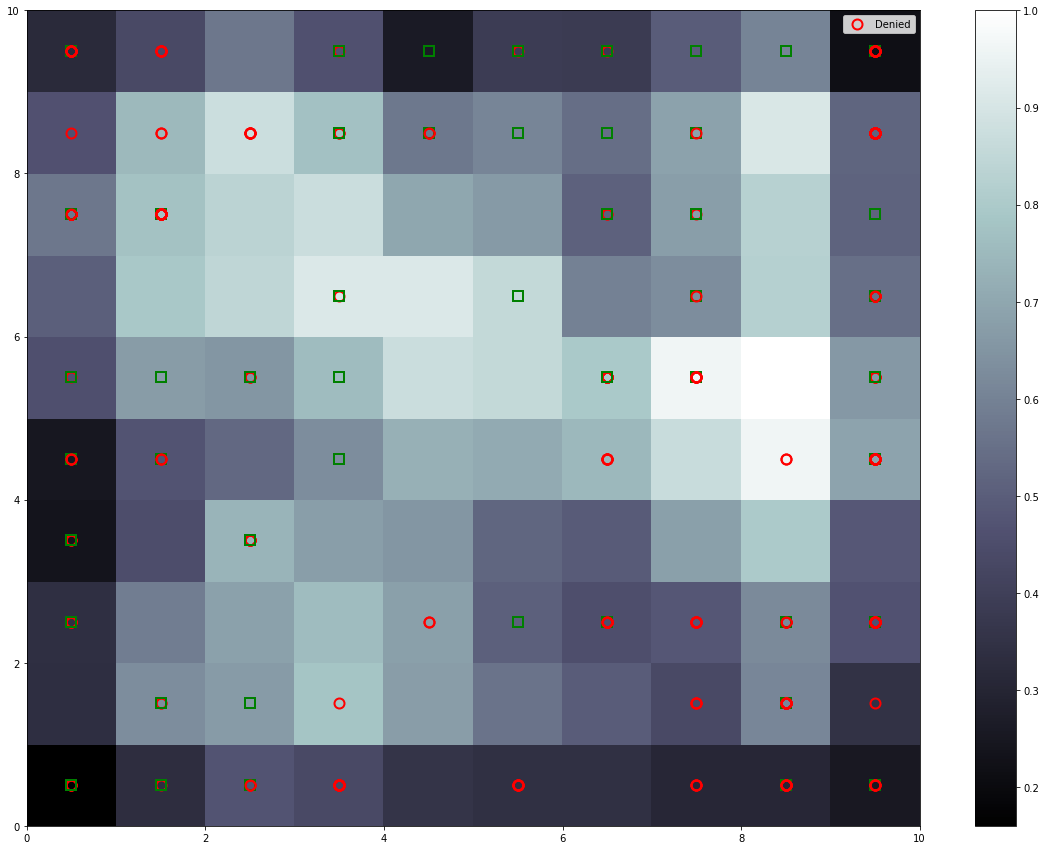

In [50]:
# Plot 
plt.figure(figsize=(20,15))
bone() # Initialize the window
pcolor(som.distance_map().T) # Will return all the median interneuron distances(MID) scaled from 0 to 1 in one matrix
colorbar() # Legend
markers = ['o', 's'] # Markers
colors = ['r', 'g'] # Colors
label = ['Denied']
for i, x in enumerate(X):
    w = som.winner(x) # Winning node for customer x
    # We place the marker in the center of the square (w[0] and w[1] are the coordinates)
    plot(w[0] + 0.5,  
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2,)
legend(label)
    

We can notice that the highest MID correspond to the white color while the smallest MID correspond to the dark color. The value are between 0 and 1 since the data have been normalized between 0 and 1.

The white winning nodes represented in white have larger MID and so they correspond to the outliers.
In the white square that represents the outlier we can notice some approval and not approval since we have both a square and a circle.

In particular we are interested in finding the ones that got approved but that we identify as outliers.

The red square represent customers that were not approved while the green the customers that were approved.

## Statistical Results

The main problem is that due to the randomness of the algorithm, the results are different everytime we run it. For this reason we decided to run the experiment for multiple epochs and get the results of each epoch.

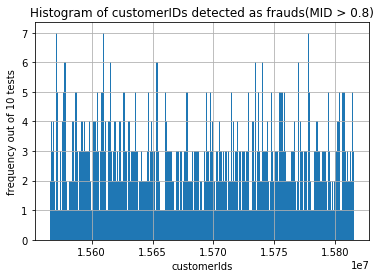

In [48]:
plt.rcParams["patch.force_edgecolor"] = False
# Display histogram with as many bins unique occurences
len(np.unique(multi_results)) # Get only the unique ID
plt.figure()
# We use an histogram to get the frequence of each ID
histogram = plt.hist(multi_results,bins = np.unique(multi_results), range = (multi_results.min(),multi_results.max()))
plt.xlabel('customerIds')
plt.ylabel('frequency out of {0} tests'.format(cv))
plt.title('Histogram of customerIDs detected as frauds(MID > {0})'.format(treshold))
plt.grid()

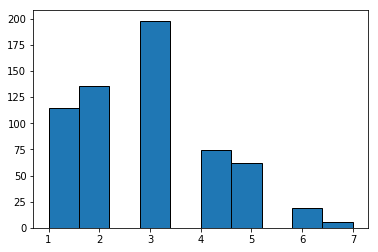

In [49]:
# Get hist frequencies
plt.rcParams["patch.force_edgecolor"] = True
frequencies = histogram[0]
plt.figure()
plt.hist(frequencies)
 
# select 95% percentile limit 
lim = np.percentile(frequencies,95)

We will now select only those customers who were above the 95% percentile limit

In [30]:
# get customers ids who were over limit
frauds = []
for i in range(0,len(frequencies)):
    if frequencies[i] >= lim: #
        frauds = np.append(frauds,histogram[1][i])
print("Found {0} customers, who were detected more than {1} times during {2} tests".format(len(frauds),lim,cv))

Found 87 customers, who were detected more than 5.0 times during 10 tests


The customer founds are the ones that probably made a fraud

In [31]:
print('Possible customer ID fraud: ')
print(frauds)

Possible customer ID fraud: 
[ 15569595.  15571081.  15571571.  15576680.  15577771.  15583680.
  15585192.  15585892.  15586183.  15586479.  15587297.  15587443.
  15589541.  15592999.  15593834.  15593959.  15594305.  15599272.
  15604536.  15607988.  15608595.  15608916.  15609758.  15609823.
  15609987.  15611318.  15611682.  15614813.  15615296.  15618258.
  15620570.  15621546.  15625501.  15627365.  15631685.  15632010.
  15633608.  15635598.  15646082.  15646594.  15651868.  15653147.
  15660528.  15666096.  15671534.  15672432.  15672637.  15672894.
  15673907.  15675926.  15677395.  15682540.  15683993.  15687765.
  15692718.  15694237.  15697460.  15699839.  15705918.  15706268.
  15711299.  15714087.  15728523.  15734008.  15736533.  15737909.
  15739548.  15746995.  15752578.  15753591.  15756538.  15757434.
  15757933.  15764444.  15769548.  15773934.  15777893.  15778589.
  15783883.  15789865.  15794204.  15803378.  15805261.  15805627.
  15812918.  15813718.  15815271.

## Part 2 - From Unsupervised to Supervised

In this second part we want to predict the probability of fraud for each customer. For this reason we will use only the features that we think will be useful for that. For example the customer ID won't be included

In [33]:
# Creating the Matrix of features
customers = df.iloc[:, 1:].values

In [36]:
# Creating the dependent variable
is_fraud = np.zeros(len(df)) 

In [40]:
# Replace the 0 with a 1 for the customer present in the fraud vector
for i in range(len(df)):
    if df.iloc[i,0] in frauds :
        is_fraud[i] = 1

## Train the Artificial Neural Network (ANN)

In [51]:
# Import libraries
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

In [52]:
# Scale the data
sc = StandardScaler()
customers = sc.fit_transform(customers)

In [57]:
# Train the ANN
model = Sequential()
# Add the first Dense Layer
model.add(Dense( units = 2, kernel_initializer = 'uniform', activation = 'relu', input_shape = (15,)))
# Add the output layer
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
# Compile the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# Fit the model to the Training Data
model.fit(customers, is_fraud, batch_size = 1, epochs = 2)

Epoch 1/2
690/690 [==============================] - 1s 2ms/step - loss: 0.5771 - acc: 0.8710
Epoch 2/2
690/690 [==============================] - 1s 1ms/step - loss: 0.3722 - acc: 0.8739


In [75]:
# Predicting the probabilities of frauds
predictions = model.predict(customers)

In [82]:
# Now we will create a vector of 2 columns containing customer ID and the probability of fraud
customer_id = df.iloc[:, 0:1]

In [87]:
fraud_customer = np.concatenate((customer_id, predictions), axis = 1)

In [146]:
# Let's create a Dataframe to visualize it better
fraud_df = pd.DataFrame(fraud_customer, columns = ['Customer ID','Fraud Probability'] )
fraud_df.sort_values(by = ['Fraud Probability'], ascending = False, inplace = True) # Sort the probabilities
fraud_df.reset_index(drop = True, inplace = True)
fraud_df.head()

,Customer ID,Fraud Probability
0,15586183.0,0.361048
1,15575605.0,0.361048
2,15666096.0,0.361048
3,15660528.0,0.358335
4,15576680.0,0.355619


## Visualize the probability of fraud

Let's visualize the customer with a probability of Fraud higher than 30 %

In [149]:
fraud_df = fraud_df[fraud_df['Fraud Probability'] >= 0.30]

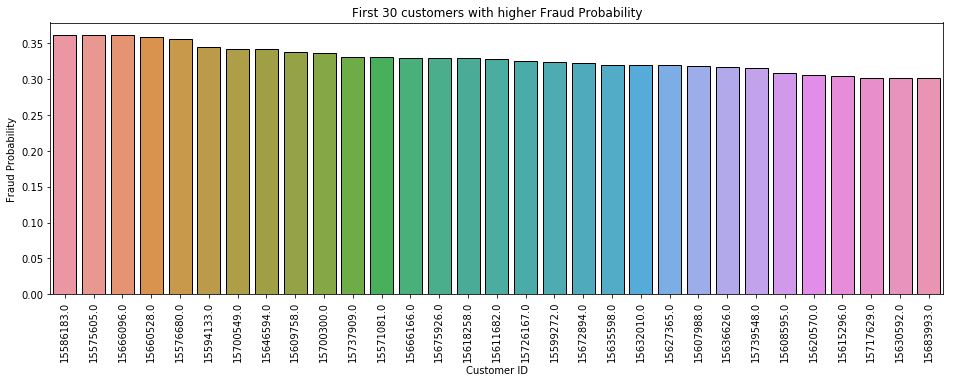

In [151]:
plt.figure(figsize = (16,5))
plt.title('First 30 customers with higher Fraud Probability')
ax = sns.barplot(x = 'Customer ID', y = "Fraud Probability", data = fraud_df, order = fraud_df['Customer ID'])
for item in ax.get_xticklabels(): item.set_rotation(90)
plt.show()